In [1]:

#%pip install ezdxf
#%pip install imutils


## Red contour

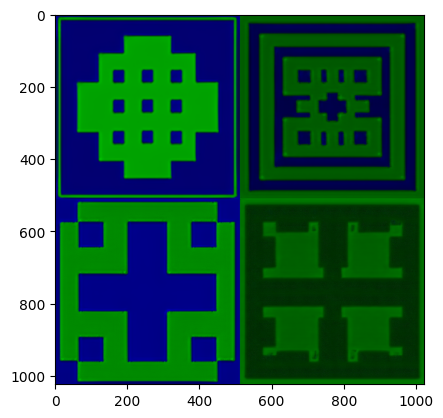

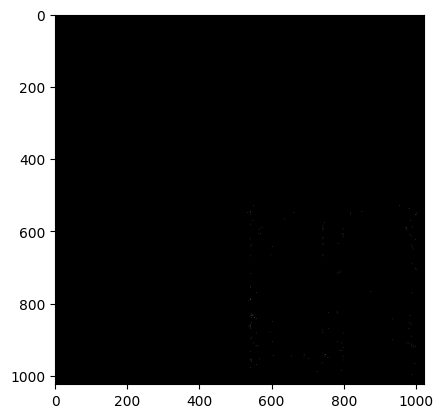

In [1]:
import numpy as np
import cv2 as cv
import imutils
from matplotlib import pyplot as plt



im = cv.imread('images/test5.png',cv.IMREAD_UNCHANGED)
im2 = im.copy()
im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
assert im is not None, "file could not be read, check with os.path.exists()"


#Channel separation
hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([0,0,0])
upper_blue = np.array([55,255,255])
# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv,lower_blue,upper_blue)





# Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
_, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

# Find contours
red_cnts = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
red_cnts = imutils.grab_contours(red_cnts) 

#Drawing
canvas = np.zeros_like(im22)


for contour in red_cnts:
    cv.drawContours(canvas, contour,-1,(0, 255, 0), 1)

    
cv.fillPoly(canvas, pts =red_cnts, color=(255,255,255))
    
cv.imwrite("RED.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 10]) 

plt.figure()
plt.imshow(im22)

plt.figure()
plt.imshow(canvas)





## Green Contour


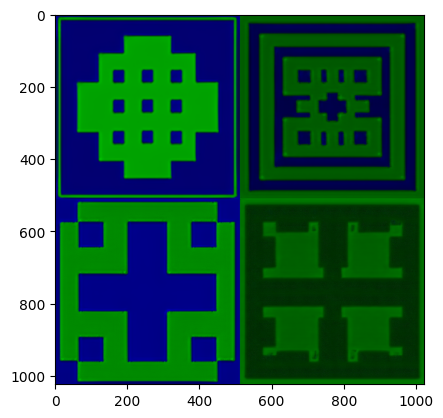

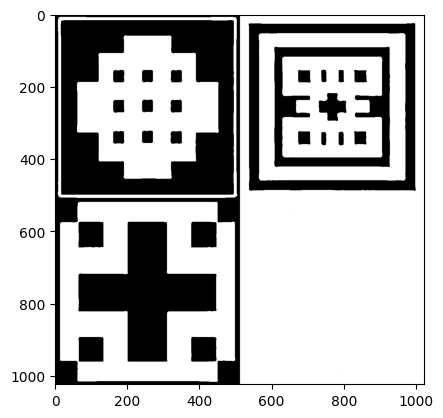

In [2]:
import numpy as np
import cv2 as cv
import imutils
from matplotlib import pyplot as plt



im = cv.imread('images/test5.png',cv.IMREAD_UNCHANGED)
im2 = im.copy()
im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
assert im is not None, "file could not be read, check with os.path.exists()"

#Channel separation
hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)
#Channel separation

# define range of blue color in HSV
lower_green = np.array([36, 100, 0])
upper_green = np.array([90, 255,255])
# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv,lower_green,upper_green)



# Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
_, thresh = cv.threshold(mask, 100, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

# Find contours
green_cnts = cv.findContours(thresh, cv.RETR_TREE , cv.CHAIN_APPROX_SIMPLE)
green_cnts = imutils.grab_contours(green_cnts) 

#Drawing
canvas = np.zeros_like(im22)

for contour in green_cnts:
    cv.drawContours(canvas, contour, -1, (0, 255, 0), 1)

cv.fillPoly(canvas, pts =green_cnts, color=(255,255,255))

    
cv.imwrite("GREEN.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 2]) 

plt.figure()
plt.imshow(im22)

plt.figure()
plt.imshow(canvas)




## border contour

4


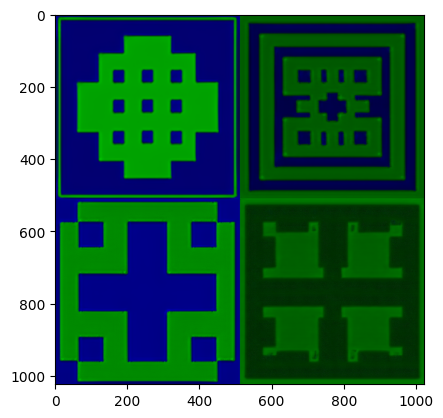

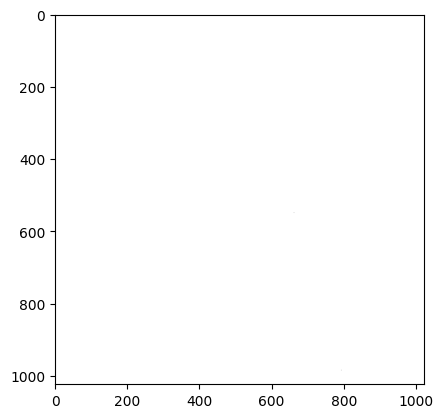

In [3]:
import numpy as np
import cv2 as cv
import imutils
from matplotlib import pyplot as plt



im = cv.imread('images/test5.png',cv.IMREAD_UNCHANGED)
im2 = im.copy()
im22 = cv.cvtColor(im2,cv.COLOR_BGR2RGB )
assert im is not None, "file could not be read, check with os.path.exists()"

hsv = cv.cvtColor(im2, cv.COLOR_BGR2HSV)
#Channel separation

# define range of blue color in HSV
lower_blue = np.array([50,0,0])
upper_blue = np.array([255,300,300])
# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv,lower_blue,upper_blue)

# Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
_, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY)

# Find contours
border_cnts = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
border_cnts = imutils.grab_contours(border_cnts) 

#Drawing
canvas = np.zeros_like(im22)

for contour in border_cnts:
    cv.drawContours(canvas, contour, -1, (0, 255, 0), 1)
cv.fillPoly(canvas, pts =border_cnts, color=(255,255,255))

cv.imwrite("SUBSTRATE.png", canvas, [cv.IMWRITE_PNG_COMPRESSION, 1]) 
print(len(contour))

plt.figure()
plt.imshow(im22)

plt.figure()
plt.imshow(canvas)



In [4]:
import ezdxf

In [5]:
dwg = ezdxf.new()#"AC1015"
msp = dwg.modelspace()

dwg.layers.new(name="conductor", dxfattribs={"color": 1})
dwg.layers.new(name="dielectric", dxfattribs={"color": 8})
dwg.layers.new(name="substrate", dxfattribs={"color": 5})


red_squeezed = [np.squeeze(cnt, axis=1) for cnt in red_cnts]
inverted_red_squeezed = [arr * [1, -1] for arr in red_squeezed]

green_squeezed = [np.squeeze(cnt, axis=1) for cnt in green_cnts]
inverted_green_squeezed = [arr * [1, -1] for arr in green_squeezed]

border_squeezed = [np.squeeze(cnt, axis=1) for cnt in border_cnts]
inverted_border_squeezed = [arr * [1, -1] for arr in border_squeezed]

len(inverted_border_squeezed)


3

In [6]:
"""To draw filled"""
layers=["conductor","dielectric", "substrate"]

for layer in layers:
    if layer=="conductor":

        for ctr in inverted_red_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'conductor'},
            )
            line.dxf.const_width = 0.5
    elif layer=="dielectric":

        for ctr in inverted_green_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'dielectric'},
            )
            line.dxf.const_width = 0.5
    elif layer=="substrate":

        for ctr in inverted_border_squeezed:
            line=msp.add_lwpolyline(
                ctr,
                format="xyb", close=True,
                dxfattribs={'layer': 'substrate'},
            )
            line.dxf.const_width = 0.5
    else:
        pass

    
    
    """To draw the outline """

#for ctr in inverted_red_squeezed:
#    for n in range(len(ctr)):
#        if n >= len(ctr) - 1:
#            n = 0
#            
#        try:
#            msp.add_line(ctr[n], ctr[n + 1], dxfattribs={"layer": "red", "lineweight": 30})
#        except IndexError:
#            pass



dwg.saveas("output.dxf")

## Elevation info

In [19]:
file = open('layers.tech', 'w')

#Layername color elevation thickness
file.write('units mm \n')

file.write('conductor red 10 10\n')
file.write('dielectric green 2 10\n')
file.write('substrate blue 0 2\n')



file.close()